In [1]:
import torch, torchvision
from torch.utils.data import random_split, DataLoader, Dataset
from torchvision import transforms as T
import os, shutil
from matplotlib import pyplot as plt
import sklearn as sk
from glob import glob
from tqdm import tqdm
from PIL import Image
import numpy as np
import torchmetrics
import timm
from time import time
import random


### Importing Dataset

In [2]:
import os, gdown 
from glob import glob
import shutil
def data_yuklab_olish(saqlash_uchun_papka, data_nomi = "lentils"):

    data_nomlari = ["salaries", "exams", "college", "cars", "car_brands", "mall", "customers", "humanitarian", "apple_disease", "insects", "cars", "crop",
                    "rice_leaf_disease", "lentils", "brain", "fruits", "aeroscapes", "cardiac", "vehicles", "cloud", "skin_lesion", "comments", "3d_data"]

    assert data_nomi in data_nomlari, f"Mavjud bo'lgan dataset {data_nomlari} dan birini kiriting!"

    if data_nomi == "rice_leaf_disease": url = "kaggle datasets download -d killa92/rice-leaf-disease-classification-dataset"
    elif data_nomi == "lentils": url = "kaggle datasets download -d killa92/lentils-classification-dataset"
    elif data_nomi == "aeroscapes": url = "kaggle datasets download -d killa92/aerospaces-semantic-segmentation-dataset"
    elif data_nomi == "cardiac": url = "kaggle datasets download -d killa92/cardiac-semantic-segmentation-dataset"
    elif data_nomi == "brain": url = "kaggle datasets download -d killa92/brain-ct-tumor-classification-dataset"
    elif data_nomi == "fruits": url = "kaggle datasets download -d killa92/fruits-classification-dataset"
    elif data_nomi == "apple_disease": url = "kaggle datasets download -d killa92/apple-disease-dataset"
    elif data_nomi == "vehicles": url = "kaggle datasets download -d killa92/vehicle-detection-dataset"
    elif data_nomi == "cloud": url = "kaggle datasets download -d killa92/cloud-quality-images-classification-dataset"
    elif data_nomi == "insects": url = "kaggle datasets download -d killa92/arthropodia-semantic-segmentation-dataset"
    elif data_nomi == "cars": url = "kaggle datasets download -d killa92/car-detect-dataset"
    elif data_nomi == "skin_lesion": url = "kaggle datasets download -d killa92/skin-lesion-image-ham-classification"
    elif data_nomi == "crop": url = "kaggle datasets download -d killa92/crop-disease-image-classification-dataset"
    elif data_nomi == "comments": url = "kaggle datasets download -d killa92/comments-nlp-sentiment-analysis-dataset"
    elif data_nomi == "car_brands": url = "kaggle datasets download mohamedaziz15/cars-brands-in-egypt"
    elif data_nomi == "3d_data": url = "kaggle datasets download glxslzt/3cla-adni"

    # Dataset yuklab olinganligini tekshirish
    if os.path.isfile(f"{saqlash_uchun_papka}/{data_nomi}.csv") or os.path.isdir(f"{saqlash_uchun_papka}/{data_nomi}"): print(f"Dataset yuklab olingan. {saqlash_uchun_papka}/{data_nomi} papkasini ni tekshiring."); pass

    # Agar dataset yuklab olinmagan bo'lsa:
    else:
        # dataset nomini aniqlash
        ds_nomi = url.split("/")[-1]
        # data saqlanadigan yo'lakni belgilash
        full_path = f"{saqlash_uchun_papka}/{ds_nomi}"
        print(f"{data_nomi} dataset yuklanmoqda...")
        # Datasetni belgilangan yo'lakka yuklab olish
        os.system(f"{url} -p {full_path}")
        # Arxivdan chiqarib olish
        shutil.unpack_archive(f"{full_path}/{ds_nomi}.zip", f"{saqlash_uchun_papka}/{ds_nomi}")
        # Original arxiv faylni o'chirib tashlash
        os.remove(f"{full_path}/{ds_nomi}.zip")
        # Yuklab olingan datasetning nomini o'zgartirish
        os.rename(f"{saqlash_uchun_papka}/{ds_nomi}", f"{saqlash_uchun_papka}/{data_nomi}")
        print(f"Tanlangan dataset {saqlash_uchun_papka}/{data_nomi} papkasiga yuklab olindi!")

data_yuklab_olish(saqlash_uchun_papka = "datasets", data_nomi = "car_brands")
data_path = "datasets/car_brands"

Dataset yuklab olingan. datasets/car_brands papkasini ni tekshiring.


### Creating Custom Dataset

In [3]:
class CustomDataset(Dataset):
    def __init__(self, data_path, img_formats = [".jpeg", ".jpg", ".bmp"], transformations = None):
        self.img_pathes = glob(f"{data_path}/*/*{[img_format for img_format in img_formats]}")
        self.transformations = transformations
        self.img_formats = img_formats
        self.get_data_info()

    def __len__(self): return len(self.img_pathes)

    def class_name_detection(self, pic_path): return os.path.basename(os.path.dirname(pic_path))


    def get_data_info(self):
    
        numbering, self.class_names, self.data_quantity = 0, {}, {}
        for one_img_path in self.img_pathes:
            class_name = self.class_name_detection(one_img_path)
            if class_name not in self.class_names: 
                self.class_names[class_name] = numbering
                numbering += 1
                    
            if class_name not  in self.data_quantity:
                self.data_quantity[class_name] = len(glob(f"{os.path.dirname(one_img_path)}/*{[img_format for img_format in self.img_formats]}"))
              
        # print(f"{self.class_names}")  
        # print(f"{self.data_quantity}")
  
    
    
    def __getitem__(self, idx):
        one_img_path = self.img_pathes[idx]
        class_name = self.class_name_detection(one_img_path)
        label  = self.class_names[class_name]
        pic = Image.open(one_img_path).convert("RGB")
        if self.transformations: pic = self.transformations(pic)
        return pic, label

img_size = 224
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
data_path = "datasets/car_brands"
tfs = T.Compose([T.ToTensor(), T.Resize((img_size, img_size)), T.Normalize(std=std, mean=mean)])
ds = CustomDataset(data_path = data_path, transformations = tfs)
print(f"ds length - {len(ds)}")


ds length - 12605


### DataLoaders

In [4]:
def create_dataloader(data_path, transformations, bs, split = [0.9, 0.05]):
    
    ds = CustomDataset(data_path = data_path, transformations = transformations)
    total_len = len(ds)
    tr_len = int(total_len * split[0])
    vl_len = int(total_len * split[1])
    ts_len = total_len - (tr_len + vl_len)

    tr_ds, vl_ds, ts_ds = random_split(ds, lengths = [tr_len, vl_len, ts_len])
    
    tr_dl = DataLoader(tr_ds, batch_size = bs, shuffle = True)
    vl_dl = DataLoader(vl_ds, batch_size = bs, shuffle = False)
    ts_dl = DataLoader(ts_ds, batch_size = 1, shuffle = False)
    # print(ts_len)
    # print(total_len)
    return tr_dl, vl_dl, ts_dl, ds.class_names

tr_dl, vl_dl, ts_dl, class_names = create_dataloader(data_path=data_path, transformations = tfs, bs=64)
print(f"length of Train data      - {len(tr_dl)}")
print(f"length of Validation data - {len(vl_dl)}")
print(f"length of Test data       - {len(ts_dl)}")
# print(f"EXISTING CLASS NAMES - {class_names}

length of Train data      - 178
length of Validation data - 10
length of Test data       - 631


### Visualization

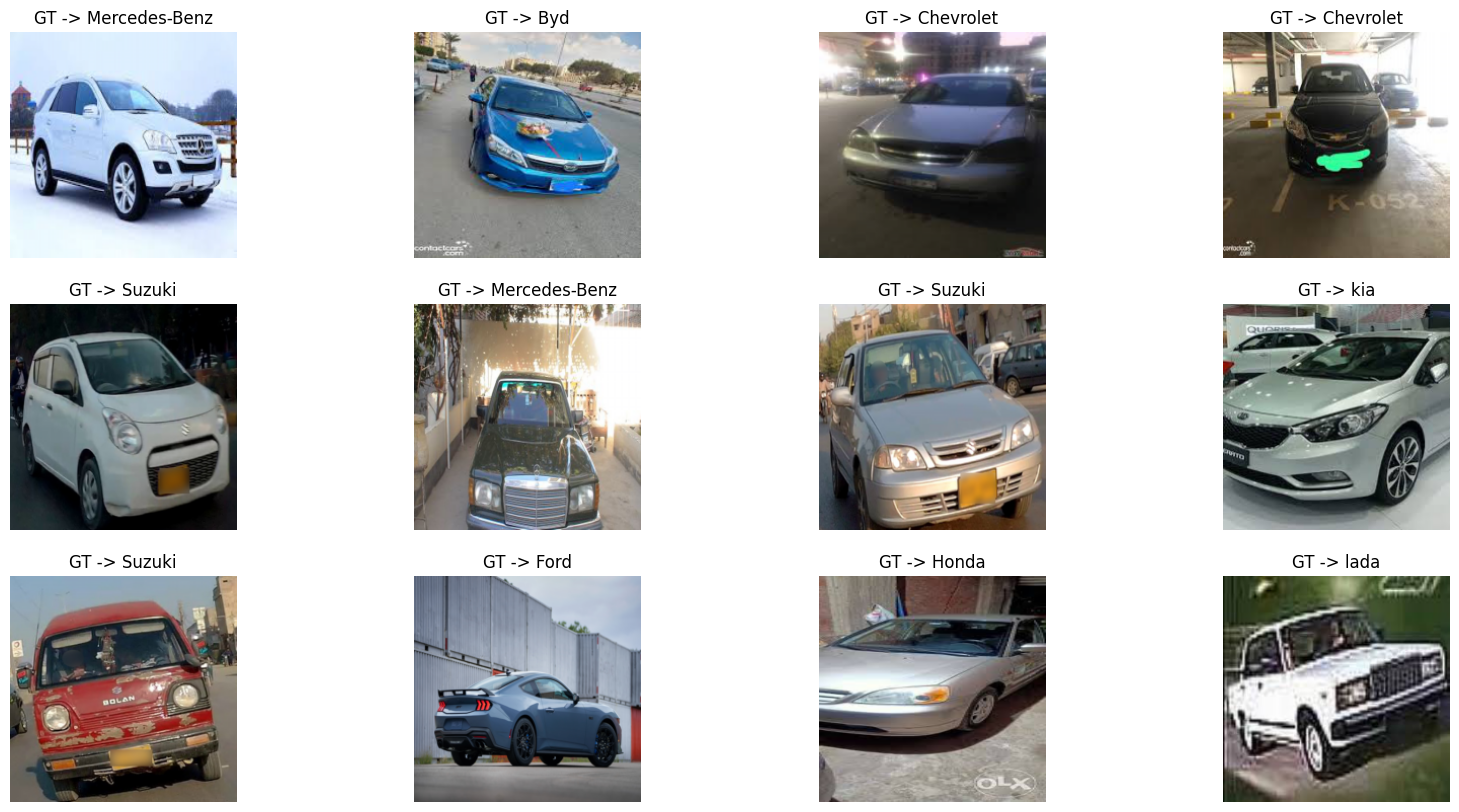

In [5]:
def tensor_2_pic(t, t_type = "rgb"):
    
    gray_tfs = T.Compose([T.Normalize(mean = [ 0.], std = [1/0.5]), T.Normalize(mean = [-0.5], std = [1])])
    rgb_tfs = T.Compose([T.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]), T.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ])])
    
    invTrans = gray_tfs if t_type == "gray" else rgb_tfs
    return (invTrans(t)*255).detach().squeeze().cpu().permute(1,2,0).numpy().astype(np.uint8) if t_type == "gray" else (invTrans(t)*255).detach().squeeze().cpu().permute(1,2,0).numpy().astype(np.uint8)
    
def visualize(data, num_pics, num_rows, cmap = None, class_names = None):
    assert cmap in ["rgb", "gray"]
    if cmap == "rgb": cmap = "viridis"
    plt.figure(figsize = (20,10))
    indexes = [random.randint(0, len(data) - 1) for _ in range(num_pics)]
    for idx, indeks in enumerate(indexes):
        pic, gt = data[indeks]
        plt.subplot(num_rows, num_pics // num_rows, idx+1)
        if cmap: plt.imshow(tensor_2_pic(pic, cmap), cmap = cmap)
        else: plt.imshow(tensor_2_pic(pic))
        plt.axis("off")
        if class_names is not None: plt.title(f"GT -> {class_names[gt]}")
        else: plt.title(f"GT -> {gt}")

visualize(tr_dl.dataset, num_pics = 12, num_rows = 3,cmap = "rgb", class_names = list(class_names.keys()))
        
    

### Class Element Quantities

C:\Users\Nodir\AppData\Local\Temp\ipykernel_20200\1700121067.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(class_names, rotation = 60)


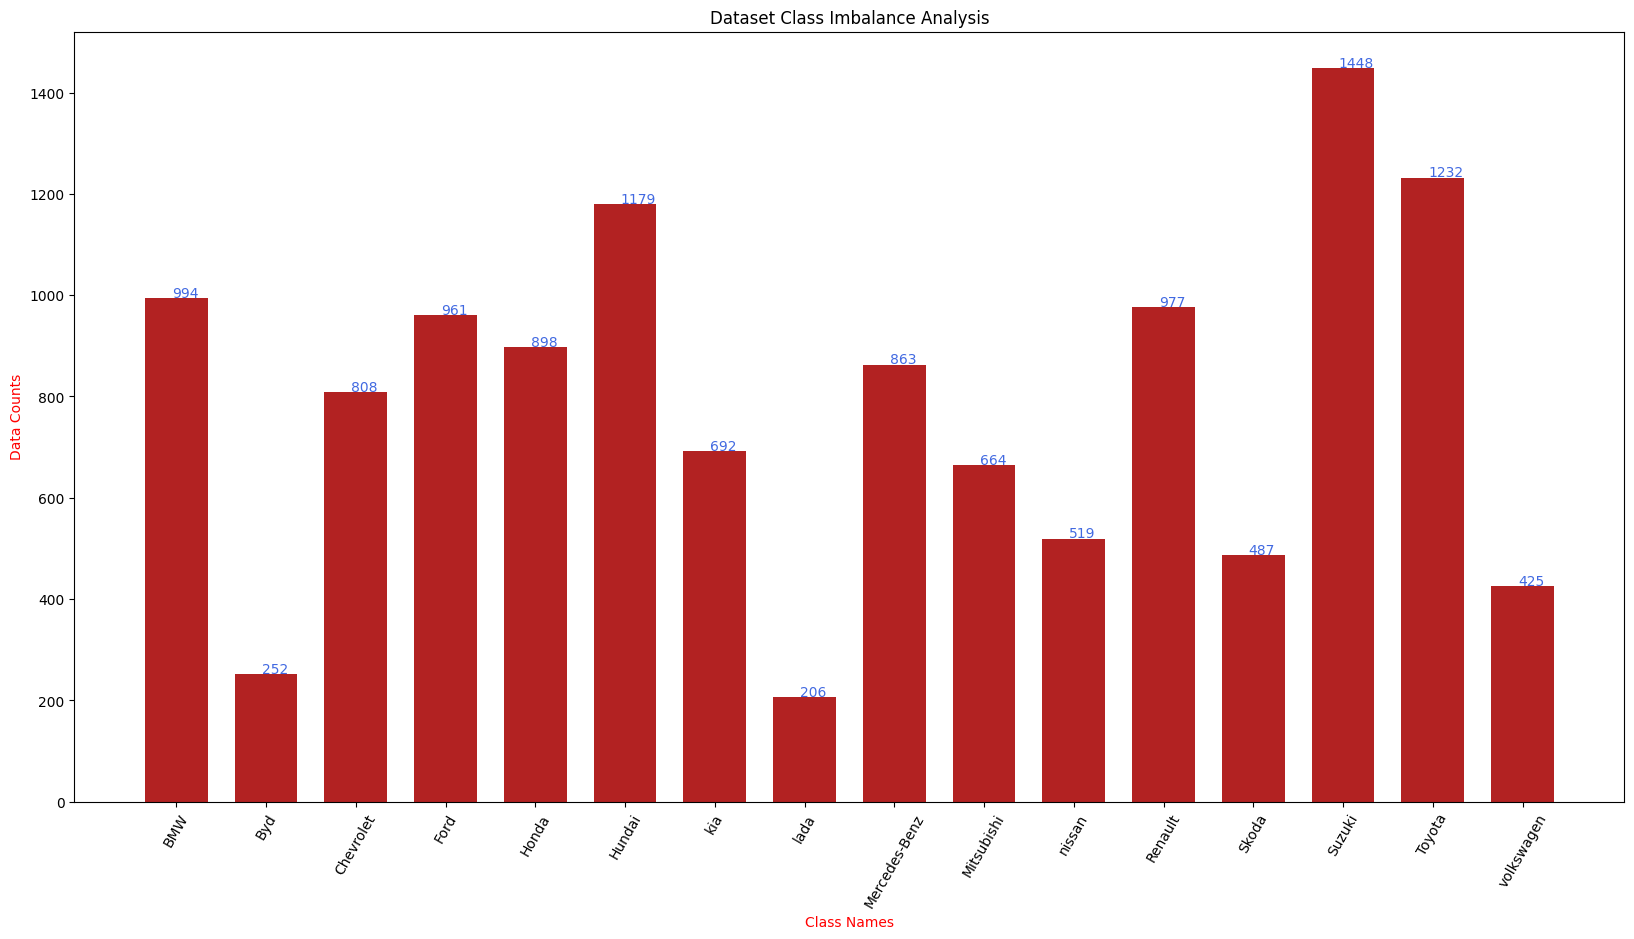

In [6]:
from matplotlib import pyplot as plt
def data_analysis(data_path, transformations):
    ds          = CustomDataset(data_path = data_path, transformations = transformations)
    data_quantity = ds.data_quantity
    width       = 0.7
    text_width  = 0.05
    text_height = 2
    class_names = list(data_quantity.keys())
    data_counts = list(data_quantity.values())

    fig, ax= plt.subplots(figsize = (20, 10))
    indexes = np.arange(len(data_counts))
    ax.bar(indexes, data_counts, width, color = "firebrick")
    ax.set_xticklabels(class_names, rotation = 60)
    ax.set(xticks = indexes, xticklabels = class_names)
    ax.set_xlabel("Class Names", color = "red")
    ax.set_ylabel("Data Counts", color = "red")
    ax.set_title("Dataset Class Imbalance Analysis")
    for i, v in enumerate(data_counts): ax.text(i-text_width, v+text_height, str(v), color= "royalblue")
data_analysis(data_path = data_path, transformations = tfs)

### Train Part

In [7]:
class TrainValidation():
    def __init__(self, model, class_names, tr_dl, vl_dl, device, patience, epochs, folder = "best_model", lr = 3e-4):
        self.model       = model
        self.class_names = class_names
        self.tr_dl       = tr_dl
        self.vl_dl       = vl_dl
        self.device      = device
        self.folder      = folder
        self.lr          = lr
        self.epochs      = epochs
        self.patience    = patience
        self.class_num   = len(self.class_names)
        
        self.not_improved= 0
        self.best_acc    = 0

        os.makedirs(self.folder, exist_ok = True)

        self.model     = timm.create_model(model, pretrained = True, num_classes = self.class_num).to(device)
        self.loss_fn   = torch.nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(params = self.model.parameters(), lr=lr)

        self.train_losses, self.train_acces =           [], []
        self.validation_losses, self.validation_acces = [], []
    @staticmethod
    def to_device(batch, device): return batch[0].to(device), batch[1].to(device) 
    def training(self):
        self.model.train()
        train_acc, train_loss = 0, 0

        for batch in tqdm(self.tr_dl, desc = "Training process..."):
            pics, labels = TrainValidation.to_device(batch = batch, device = self.device)
            preds = self.model(pics)
            tr_loss = self.loss_fn(preds, labels)
            
            self.optimizer.zero_grad()
            tr_loss.backward()
            self.optimizer.step()

            train_loss += tr_loss.item()
            train_acc  += (torch.argmax(preds, dim = 1) == labels).sum().item()

        train_loss /= len(self.tr_dl)
        train_acc = (train_acc / len(self.tr_dl.dataset)) * 100

        self.train_losses.append(train_loss)
        self.train_acces.append(train_acc)
        return train_loss, train_acc
        
    def validation(self):
        self.model.eval()
        vl_loss, vl_acc = 0, 0
        with torch.no_grad():
            for batch in tqdm(self.vl_dl, desc = "Validation proccess..."):
                pics, labels = TrainValidation.to_device(batch = batch, device = self.device)
                preds = self.model(pics)
                loss = self.loss_fn(preds, labels)

                vl_loss += loss.item()
                vl_acc += (torch.argmax(preds, dim=1) == labels).sum().item()

        vl_loss /= len(self.vl_dl)
        vl_acc = (vl_acc / len(vl_dl.dataset)) * 100

        self.validation_losses.append(vl_loss)
        self.validation_acces.append(vl_acc)
        return vl_loss, vl_acc

    def result(self, epoch, metric1, metric2, process):
        print(f"{epoch+1}/{self.epochs}")
        print(f"For {epoch+1} epoch {process} loss is     -> {metric1:.2f}")
        print(f"For {epoch+1} epoch {process} accuracy is -> {metric2:.2f}")

    def run(self):
        
        print(f"Training is about to begin...")
        for epoch in range(self.epochs):
            train_loss, train_acc  = self.training()
            self.result(epoch, train_loss, train_acc, "Training")

            vl_loss, vl_acc = self.validation()
            self.result(epoch, vl_loss, vl_acc, "Validation")

            if vl_acc > self.best_acc:
                self.best_acc = vl_acc
                torch.save(self.model.state_dict(), os.path.join(self.folder, "CarBrands_BestModel"))
            else: self.not_improved += 1

            if self.not_improved == self.patience:
                print(f"Model has not improved during {self.patience} epochs.")
                print(f"Best model accuracy is - {self.best_acc:.2f}")
                break


        
            

In [8]:
model = "rexnet_150"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
trainer = TrainValidation(model = model, tr_dl=tr_dl, vl_dl =  vl_dl, class_names = class_names, patience = 5, folder ="best_model", epochs=30, device = device)
trainer.run()

Training is about to begin...


Training process...:   2%|█▎                                                           | 4/178 [00:47<33:56, 11.70s/it]C:\Users\Nodir\anaconda3\envs\teachaiuz\lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training process...: 100%|███████████████████████████████████████████████████████████| 178/178 [34:31<00:00, 11.64s/it]


1/30
For 1 epoch Training loss is     -> 1.37
For 1 epoch Training accuracy is -> 58.07


Validation proccess...: 100%|██████████████████████████████████████████████████████████| 10/10 [00:32<00:00,  3.21s/it]


1/30
For 1 epoch Validation loss is     -> 0.76
For 1 epoch Validation accuracy is -> 78.89


Training process...: 100%|███████████████████████████████████████████████████████████| 178/178 [34:27<00:00, 11.61s/it]


2/30
For 2 epoch Training loss is     -> 0.31
For 2 epoch Training accuracy is -> 90.68


Validation proccess...: 100%|██████████████████████████████████████████████████████████| 10/10 [00:33<00:00,  3.32s/it]


2/30
For 2 epoch Validation loss is     -> 0.68
For 2 epoch Validation accuracy is -> 80.79


Training process...: 100%|███████████████████████████████████████████████████████████| 178/178 [34:37<00:00, 11.67s/it]


3/30
For 3 epoch Training loss is     -> 0.06
For 3 epoch Training accuracy is -> 98.47


Validation proccess...: 100%|██████████████████████████████████████████████████████████| 10/10 [00:36<00:00,  3.64s/it]


3/30
For 3 epoch Validation loss is     -> 0.67
For 3 epoch Validation accuracy is -> 83.02


Training process...: 100%|███████████████████████████████████████████████████████████| 178/178 [28:59<00:00,  9.77s/it]


4/30
For 4 epoch Training loss is     -> 0.02
For 4 epoch Training accuracy is -> 99.62


Validation proccess...: 100%|██████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.79s/it]


4/30
For 4 epoch Validation loss is     -> 0.65
For 4 epoch Validation accuracy is -> 83.97


Training process...: 100%|███████████████████████████████████████████████████████████| 178/178 [28:46<00:00,  9.70s/it]


5/30
For 5 epoch Training loss is     -> 0.01
For 5 epoch Training accuracy is -> 99.77


Validation proccess...: 100%|██████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.79s/it]


5/30
For 5 epoch Validation loss is     -> 0.65
For 5 epoch Validation accuracy is -> 83.65


Training process...: 100%|███████████████████████████████████████████████████████████| 178/178 [28:44<00:00,  9.69s/it]


6/30
For 6 epoch Training loss is     -> 0.01
For 6 epoch Training accuracy is -> 99.70


Validation proccess...: 100%|██████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.78s/it]


6/30
For 6 epoch Validation loss is     -> 0.78
For 6 epoch Validation accuracy is -> 82.22


Training process...: 100%|███████████████████████████████████████████████████████████| 178/178 [28:44<00:00,  9.69s/it]


7/30
For 7 epoch Training loss is     -> 0.06
For 7 epoch Training accuracy is -> 98.11


Validation proccess...: 100%|██████████████████████████████████████████████████████████| 10/10 [00:28<00:00,  2.82s/it]


7/30
For 7 epoch Validation loss is     -> 0.68
For 7 epoch Validation accuracy is -> 84.29


Training process...: 100%|███████████████████████████████████████████████████████████| 178/178 [28:42<00:00,  9.68s/it]


8/30
For 8 epoch Training loss is     -> 0.08
For 8 epoch Training accuracy is -> 97.24


Validation proccess...: 100%|██████████████████████████████████████████████████████████| 10/10 [00:26<00:00,  2.67s/it]


8/30
For 8 epoch Validation loss is     -> 0.76
For 8 epoch Validation accuracy is -> 83.49


Training process...: 100%|███████████████████████████████████████████████████████████| 178/178 [28:39<00:00,  9.66s/it]


9/30
For 9 epoch Training loss is     -> 0.05
For 9 epoch Training accuracy is -> 98.59


Validation proccess...: 100%|██████████████████████████████████████████████████████████| 10/10 [00:28<00:00,  2.81s/it]


9/30
For 9 epoch Validation loss is     -> 0.68
For 9 epoch Validation accuracy is -> 83.49


Training process...: 100%|███████████████████████████████████████████████████████████| 178/178 [28:38<00:00,  9.65s/it]


10/30
For 10 epoch Training loss is     -> 0.04
For 10 epoch Training accuracy is -> 98.74


Validation proccess...: 100%|██████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.77s/it]


10/30
For 10 epoch Validation loss is     -> 0.74
For 10 epoch Validation accuracy is -> 85.40


Training process...: 100%|███████████████████████████████████████████████████████████| 178/178 [28:49<00:00,  9.72s/it]


11/30
For 11 epoch Training loss is     -> 0.02
For 11 epoch Training accuracy is -> 99.32


Validation proccess...: 100%|██████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.79s/it]


11/30
For 11 epoch Validation loss is     -> 0.68
For 11 epoch Validation accuracy is -> 85.71


Training process...: 100%|███████████████████████████████████████████████████████████| 178/178 [28:51<00:00,  9.73s/it]


12/30
For 12 epoch Training loss is     -> 0.01
For 12 epoch Training accuracy is -> 99.75


Validation proccess...: 100%|██████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.75s/it]


12/30
For 12 epoch Validation loss is     -> 0.65
For 12 epoch Validation accuracy is -> 87.62


Training process...: 100%|███████████████████████████████████████████████████████████| 178/178 [28:40<00:00,  9.66s/it]


13/30
For 13 epoch Training loss is     -> 0.01
For 13 epoch Training accuracy is -> 99.76


Validation proccess...: 100%|██████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.73s/it]

13/30
For 13 epoch Validation loss is     -> 0.67
For 13 epoch Validation accuracy is -> 87.46
Model has not improved during 5 epochs.
Best model accuracy is - 87.62


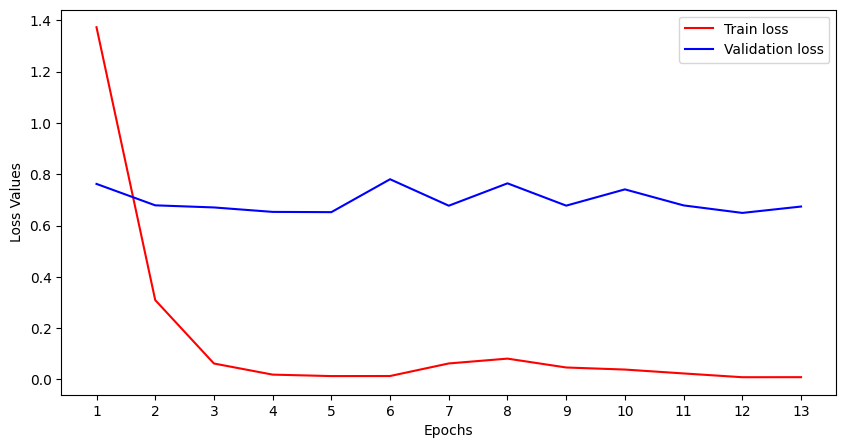

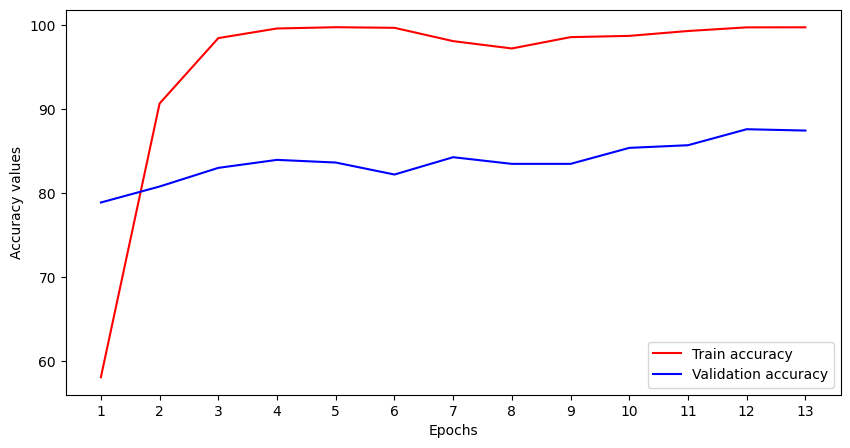

In [9]:
class PlotLearningCurves:
    def __init__(self, train_losses, validation_losses, train_acces, validation_acces):
        self.train_losses = train_losses
        self.validation_losses = validation_losses
        self.train_acces = train_acces
        self.validation_acces = validation_acces

    def draw(self, array1, array2, label1, label2, color1, color2):
        plt.plot(array1, label = label1, c = color1)
        plt.plot(array2, label = label2, c = color2)

    def create_figure(self): return plt.figure(figsize = (10, 5))

    def decorate(self, ylabel, xlabel = "Epochs"):
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.xticks(ticks = np.arange(len(self.train_acces)), labels = [i for i in range(1, len(self.train_acces) + 1)])
        plt.legend()
        plt.show()

    def demonstrate(self):
        self.create_figure()
        self.draw( array1 = self.train_losses, array2 =self.validation_losses, label1 = "Train loss", label2 = "Validation loss", color1 = "red", color2 = "blue"); self.decorate(ylabel = "Loss Values")

        self.create_figure()   
        self.draw( array1 = self.train_acces, array2 = self.validation_acces, label1 = "Train accuracy", label2 = "Validation accuracy", color1 = "red", color2 = "blue"); self.decorate(ylabel = "Accuracy values")

PlotLearningCurves(train_losses =trainer.train_losses, validation_losses = trainer.validation_losses, train_acces = trainer.train_acces, validation_acces = trainer.validation_acces).demonstrate()



In [10]:
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2, seaborn as sns
from sklearn.metrics import confusion_matrix

In [11]:
class Denormalize:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std): t.mul_(s).add_(m)
        return tensor
        
class Inference:
    
    def __init__(self, model, device, class_names, img_size = 224, std = std, mean = mean):
        self.denormalize = Denormalize(mean=mean, std=std)
        self.model = model
        self.model.eval()
        self.img_size = img_size
        self.device = device
        self.class_names = class_names
        
       
        
    def tensor_2_pic(self, tensor):
        tensor = self.denormalize(tensor)
        tensor = tensor.permute(1,2,0)
        return (tensor.cpu().numpy()  * 255).astype(np.uint8)
        
    def gradcam(self, pic):
        cam = GradCAMPlusPlus(self.model, target_layers = [self.model.features[-1]], use_cuda = "cuda")
        cam_gt = cam(pic.unsqueeze(0))[0, :]
        return cam_gt

    def inference(self, model,  ts_dl, num_pics, num_rows):
        pics, preds, pred_classes, ground_truth = [], [], [], []
        acc, numbering = 0, 1
        with torch.no_grad():
            self.model.eval()
            for idx, batch in tqdm(enumerate(ts_dl), desc = "Testing precess..."):
                # print(batch)
                pic, label = TrainValidation.to_device(batch = batch, device = self.device)
                pred = self.model(pic)
                pred_class = torch.argmax(pred, dim=1)
                acc += (pred_class.view(-1) == label.view(-1)).sum().item()
                
                pics.append(pic[0])
                preds.append(pred[0])
                pred_classes.append(pred_class[0].item())
                ground_truth.append(label[0].item())
                total_samples = sum(len(batch[1]) for batch in ts_dl)
                
            print(f"test accuracy is ({(acc / total_samples * 100):.2f}%")
                                  

            

        plt.figure(figsize = (20, 10))
        indexes = [random.randint(0, len(pics) - 1) for i in range(num_pics)]
        for idx, value in enumerate(indexes):
            pic = self.tensor_2_pic(pics[value].squeeze()) # pic - 2D
            pred_value = pred_classes[value]
            gt_value = ground_truth[value]
        
            plt.subplot(num_rows, num_pics//num_rows, numbering)
            numbering += 1
            plt.imshow(pic, cmap = "gray")
            plt.axis("off")

            cam_gt = self.gradcam(pics[value]) # 3D -> 4D
            # cam_gt = cam_gt.
            if cam_gt.ndim == 2:
                cam_gt = np.stack([cam_gt] * 3, axis=-1)
            mark = show_cam_on_image(pic / 255, cam_gt, image_weight=0.4, use_rgb=True) # rasm * 255 -> int -> float # rasmimiz qanchalik ko'rinishi
            plt.imshow(cv2.resize(mark, (self.img_size, self.img_size), interpolation=cv2.INTER_LINEAR), alpha=0.7, cmap='jet')
            plt.axis("off")

            # Confusion matrix #
            pred = preds[value] # confusion metricsga logits kiradi (bashorat_klass emas)
            # If 1D, add a batch dimension
            if pred.dim() == 1: pred = pred.unsqueeze(0) # 2D            

            # Title with GT and Prediction
            if self.class_names:
                
                gt_name = self.class_names[gt_value]
                pred_name = self.class_names[pred_value]
                color = "green" if gt_name == pred_name else "red"
                plt.title(f"Javob -> {gt_name} ; Bashorat -> {pred_name}", color=color)    

        plt.figure(figsize=(20, 10))   
        cm = confusion_matrix(ground_truth, pred_classes)
        sns.heatmap(cm, annot=True, xticklabels=self.class_names, yticklabels=self.class_names)
        plt.title("Confusion Matrix")
        plt.xlabel("Bashoratlar")
        plt.ylabel("Javoblar")
        plt.show()    


C:\Users\Nodir\AppData\Local\Temp\ipykernel_20200\2162538292.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model/CarBrands_BestM

test accuracy is (87.48%


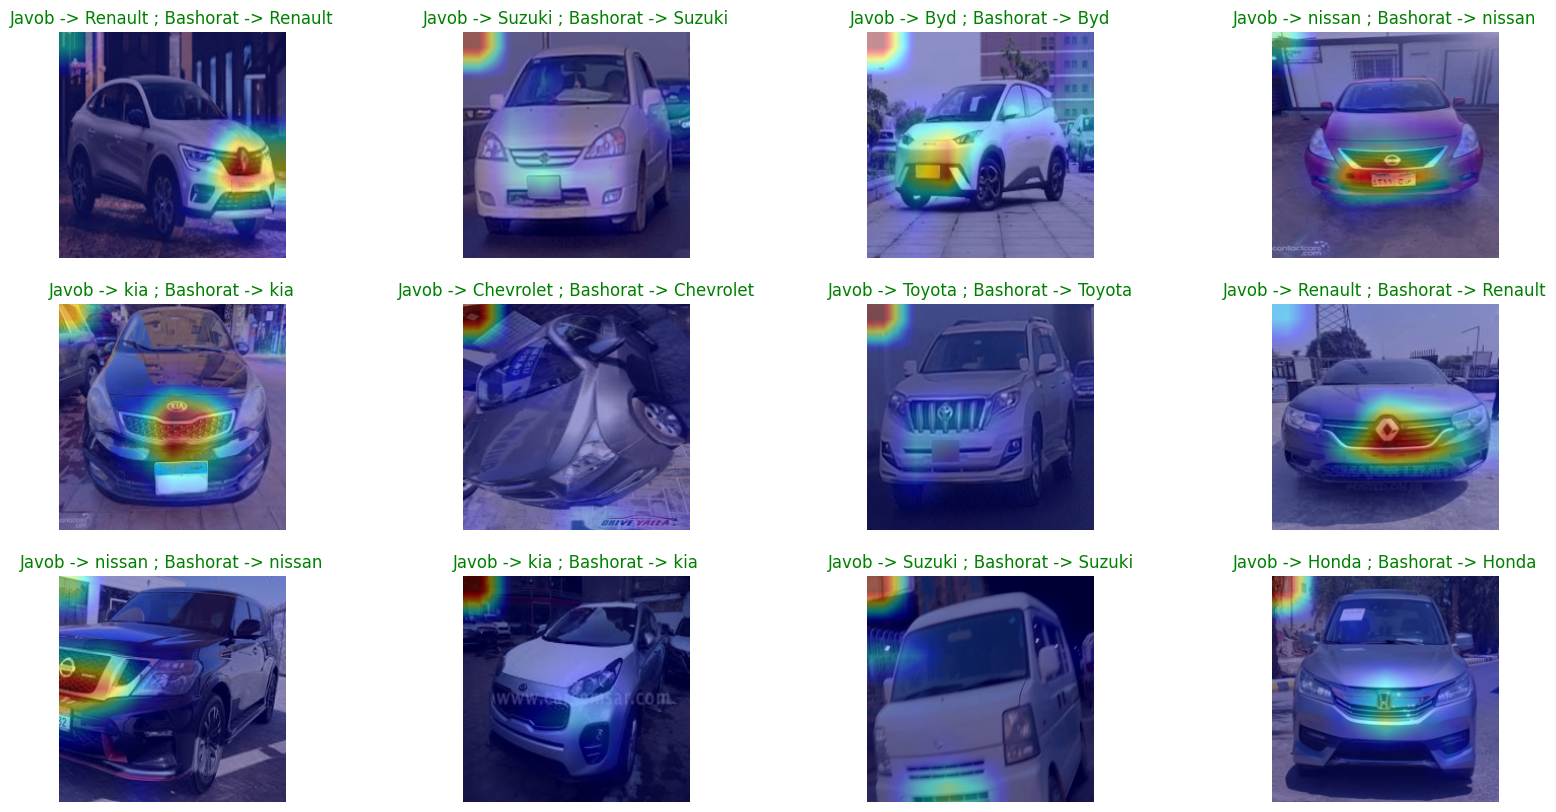

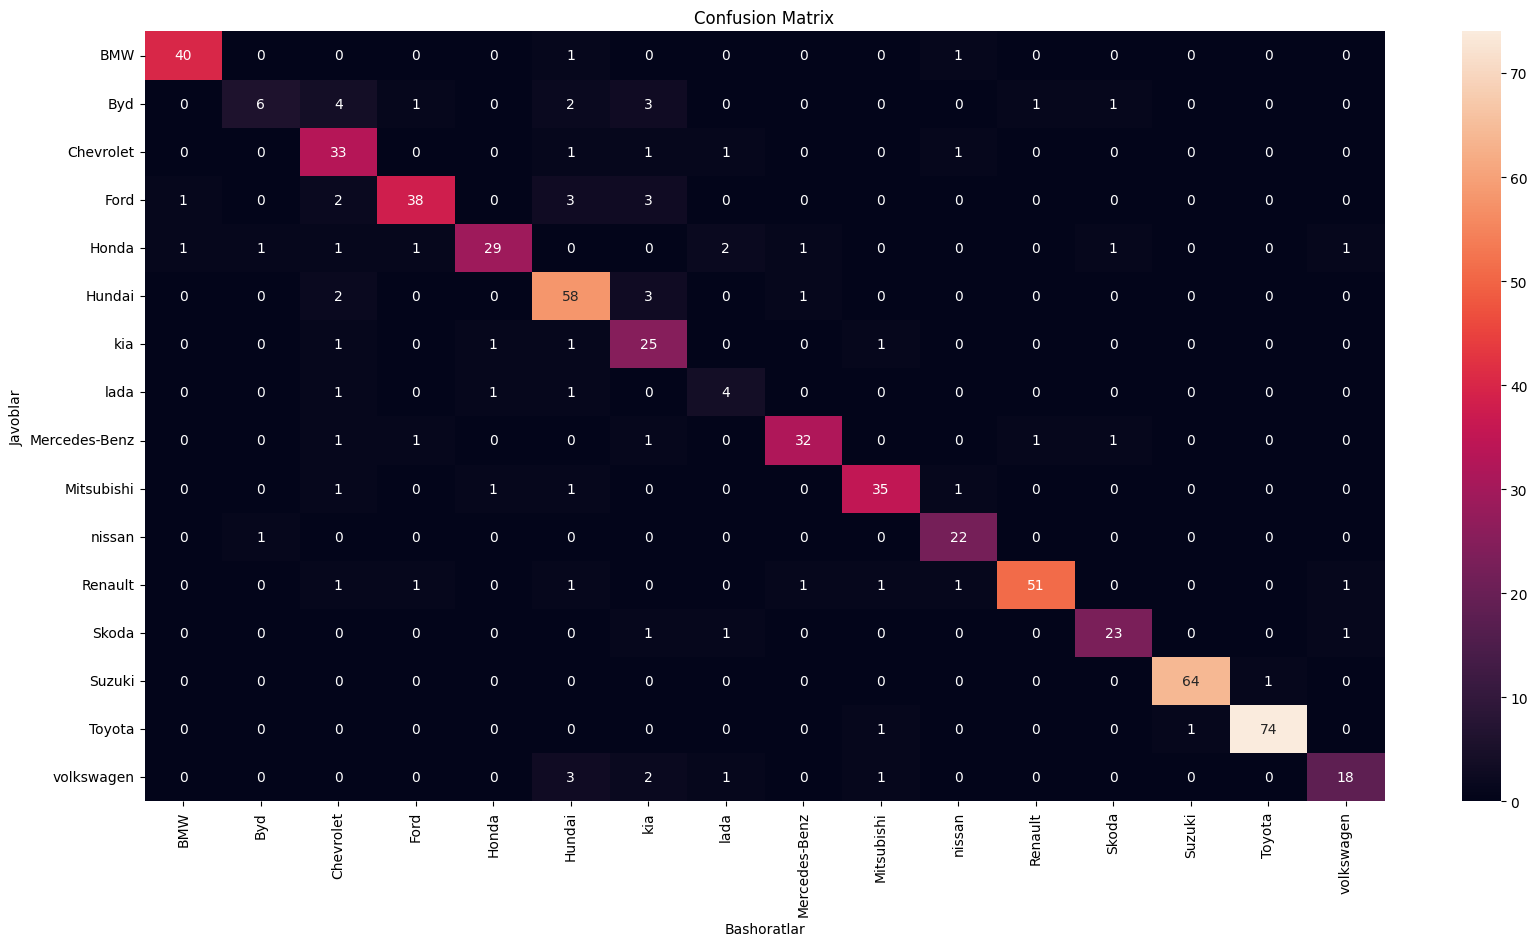

In [31]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
model = timm.create_model(model_name = "rexnet_150", pretrained  = False, num_classes = len(class_names)).to(device)
model.load_state_dict(torch.load("best_model/CarBrands_BestModel"))
chizuvchi = Inference(
    model=model,
    device=device,
    class_names=list(class_names.keys()),  # List of class names
    img_size=224
)

chizuvchi.inference(model = model, ts_dl = ts_dl, num_pics=12, num_rows=3)